In [2]:
print(1)

1


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

import warnings; warnings.filterwarnings("ignore")

In [4]:
import os
import cv2
import numpy as np

# Load all images from a folder
def load_images(folder, target_size=(256, 256)):
    images = []
    filenames = os.listdir(folder)  # Load all files in the folder
    for filename in filenames:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = cv2.resize(img, target_size)  # Resize to target size
            images.append(img)
    return np.array(images)

# Simulate low-resolution images by downscaling
def downscale_images(images, scale=2):
    low_res = []
    for img in images:
        lr = cv2.resize(img, (img.shape[1] // scale, img.shape[0] // scale))  # Downscale
        lr = cv2.resize(lr, (img.shape[1], img.shape[0]))  # Upscale back to original size
        low_res.append(lr)
    return np.array(low_res)


In [5]:

hr_train_images  = load_images("/kaggle/input/div2k-high-resolution-images/DIV2K_train_HR/DIV2K_train_HR")
lr_train_images  = downscale_images(hr_train_images)

hr_val_images = load_images("/kaggle/input/div2k-high-resolution-images/DIV2K_valid_HR/DIV2K_valid_HR")
lr_val_images = downscale_images(hr_val_images)

# Normalize images
hr_train_images, lr_train_images = hr_train_images / 255.0, lr_train_images / 255.0
hr_val_images, lr_val_images = hr_val_images / 255.0, lr_val_images / 255.0

In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, Callback
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Define SRCNN Model
def build_srcnn():
    model = Sequential([
        Conv2D(64, (9, 9), activation='relu', padding='same', input_shape=(256, 256, 3)),
        Conv2D(32, (5, 5), activation='relu', padding='same'),
        Conv2D(3, (5, 5), activation='linear', padding='same')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=MeanSquaredError())
    return model

# Train SRCNN
model = build_srcnn()

In [11]:
# Initialize lists to store metric values
psnr_values = []
ssim_values = []
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
learning_rates = []

class MetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_predictions = model.predict(lr_val_images)

        avg_psnr = np.mean([
            psnr(hr_val_images[i], val_predictions[i], data_range=1)
            for i in range(len(hr_val_images))
        ])

        avg_ssim = np.mean([
            ssim(hr_val_images[i], val_predictions[i], data_range=1, win_size=3, channel_axis=-1)  
            for i in range(len(hr_val_images))
        ])

        # Store values
        psnr_values.append(avg_psnr)
        ssim_values.append(avg_ssim)
        train_losses.append(logs["loss"])
        val_losses.append(logs["val_loss"])

        optimizer = model.optimizer
        learning_rates.append(optimizer.learning_rate.numpy())  # ✅ Fixed learning rate access

        print(f"Epoch {epoch+1} - PSNR: {avg_psnr:.2f} dB, SSIM: {avg_ssim:.4f}, Loss: {logs['loss']:.4f}, Val Loss: {logs['val_loss']:.4f}")

        print(f"Epoch {epoch+1} - PSNR: {avg_psnr:.2f} dB, SSIM: {avg_ssim:.4f}, Loss: {logs['loss']:.4f}, Val Loss: {logs['val_loss']:.4f}")


In [12]:
# Define Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train model with callback
history = model.fit(
    lr_train_images, hr_train_images,
    validation_data=(lr_val_images, hr_val_images),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping, MetricsCallback()],
    verbose=1
)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/steptep - loss: 0.
Epoch 1 - PSNR: 20.55 dB, SSIM: 0.5241, Loss: 0.0112, Val Loss: 0.0103
Epoch 1 - PSNR: 20.55 dB, SSIM: 0.5241, Loss: 0.0112, Val Loss: 0.0103
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - loss: 0.0117 - val_loss: 0.0103
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/steptep - loss: 0.
Epoch 2 - PSNR: 21.13 dB, SSIM: 0.5482, Loss: 0.0094, Val Loss: 0.0092
Epoch 2 - PSNR: 21.13 dB, SSIM: 0.5482, Loss: 0.0094, Val Loss: 0.0092
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - loss: 0.0099 - val_loss: 0.0092
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/steptep - loss: 0.
Epoch 3 - PSNR: 21.52 dB, SSIM: 0.5673, Loss: 0.0086, Val Loss: 0.0085
Epoch 3 - PSNR: 21.52 dB, SSIM: 0.5673, Loss: 0.0086, Val Loss: 0.0085
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - loss: 0.0088 - val_loss: 0.0085
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/steptep - loss: 0.
Epoch 4 - PSNR: 21.84 dB, SSIM: 0.5848, Loss: 0.0080, Val Loss: 0.0080
Epoch 4 - PSNR: 21.

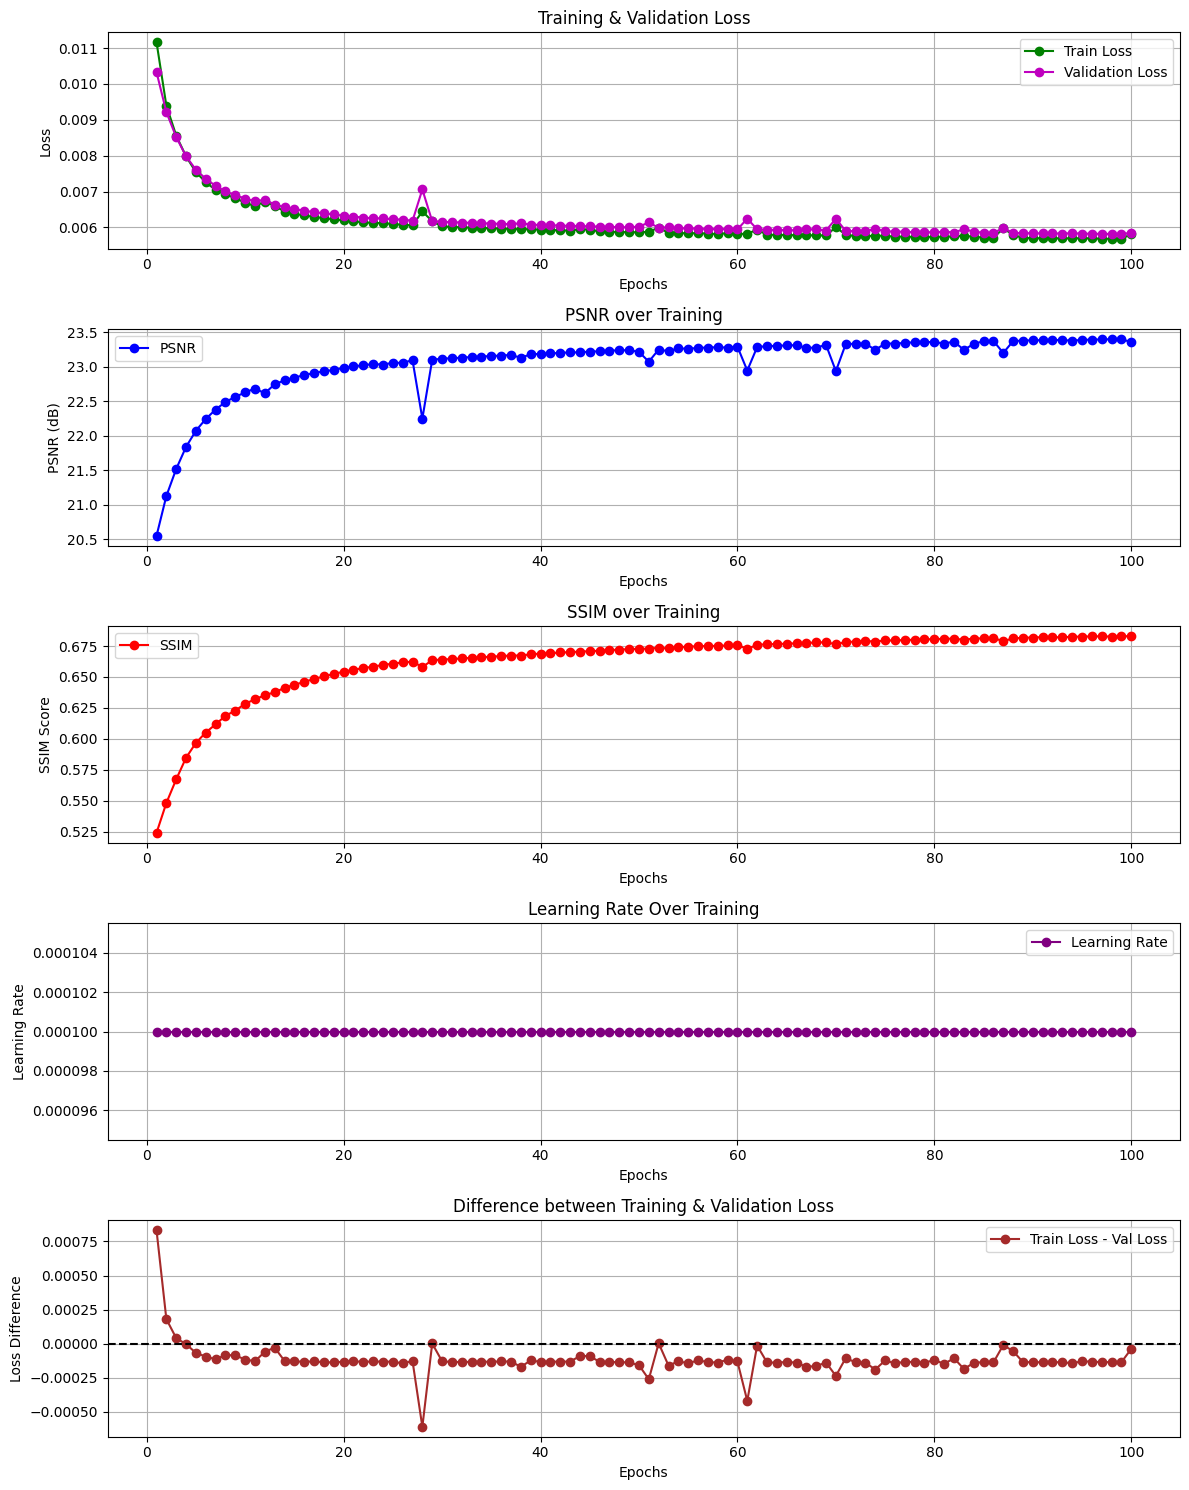

In [13]:
# ============================
# 📊 PLOTTING TRAINING METRICS
# ============================
num_plots = 5
plt.figure(figsize=(12, 15))

# 1. Training & Validation Loss
plt.subplot(num_plots, 1, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', color='g', label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='o', color='m', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()

# 2. PSNR over Training
plt.subplot(num_plots, 1, 2)
plt.plot(range(1, len(psnr_values) + 1), psnr_values, marker='o', color='b', label="PSNR")
plt.xlabel("Epochs")
plt.ylabel("PSNR (dB)")
plt.title("PSNR over Training")
plt.legend()
plt.grid()

# 3. SSIM over Training
plt.subplot(num_plots, 1, 3)
plt.plot(range(1, len(ssim_values) + 1), ssim_values, marker='o', color='r', label="SSIM")
plt.xlabel("Epochs")
plt.ylabel("SSIM Score")
plt.title("SSIM over Training")
plt.legend()
plt.grid()

# 4. Learning Rate Over Training
plt.subplot(num_plots, 1, 4)
plt.plot(range(1, len(learning_rates) + 1), learning_rates, marker='o', color='purple', label="Learning Rate")
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Over Training")
plt.legend()
plt.grid()

# 5. Difference between Training & Validation Loss
plt.subplot(num_plots, 1, 5)
loss_diff = np.array(train_losses) - np.array(val_losses)
plt.plot(range(1, len(loss_diff) + 1), loss_diff, marker='o', color='brown', label="Train Loss - Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss Difference")
plt.title("Difference between Training & Validation Loss")
plt.axhline(0, color='black', linestyle='--')  # Zero reference line
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [14]:
val_preds = model.predict(lr_val_images)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


In [15]:
psnr_value = psnr(hr_val_images[0], val_preds[0])
ssim_value = ssim(hr_val_images[0], val_preds[0], win_size=3, channel_axis=-1, data_range=1.0)

print(f"PSNR: {psnr_value}, SSIM: {ssim_value}")


PSNR: 31.402012130644998, SSIM: 0.8797836433136762


In [16]:
def visualized_diff(i):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(lr_val_images[i])
    axes[0].set_title("Low-Res")
    
    axes[1].imshow(val_preds[i])
    axes[1].set_title("Super-Resolved")
    
    axes[2].imshow(hr_val_images[i])
    axes[2].set_title("High-Res")
    
    plt.show()


In [17]:
print(len(lr_val_images))

100


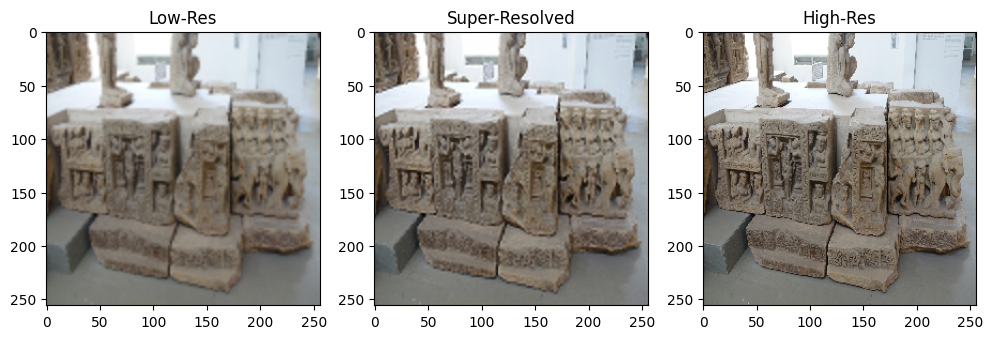

In [18]:
visualized_diff(1)

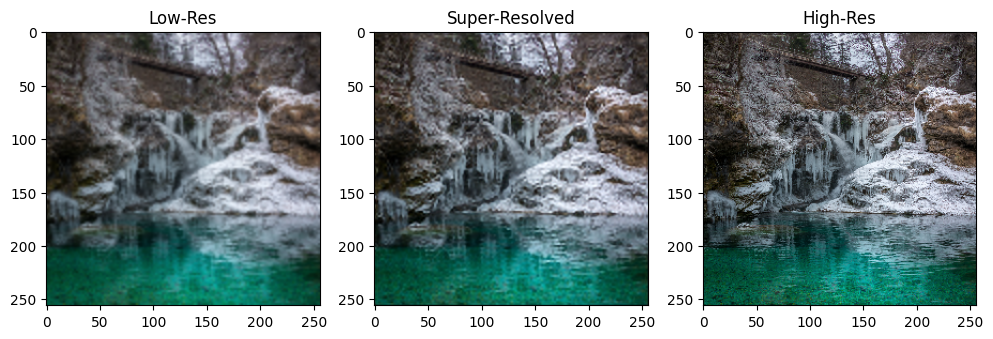

In [19]:
visualized_diff(2)

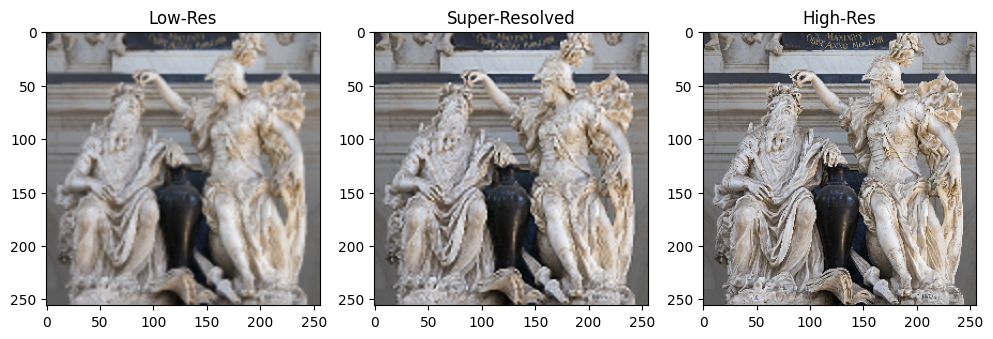

In [20]:
visualized_diff(80)

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def myfunc(image_path, model):
    """
    Loads an image from a file path, processes it as a low-res image,
    passes it through the SRCNN model to get a super-resolved version,
    and visualizes the original low-res and the predicted high-res images.
    
    Args:
        image_path (str): The file path of the image.
        model: Trained SRCNN model.
        target_size (tuple): The size to which the image is resized.
    """
    # Load the image using cv2
    target_size=(256,256)
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Could not load image!")
        return
    # Convert BGR (OpenCV default) to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Resize image to target size
    img = cv2.resize(img, target_size)
    # Normalize image
    img_norm = img / 255.0
    
    # Simulate low resolution: downscale and upscale
    scale = 2
    lr = cv2.resize(img, (img.shape[1] // scale, img.shape[0] // scale))
    lr = cv2.resize(lr, (img.shape[1], img.shape[0]))
    lr_norm = lr / 255.0

    # Predict super-resolved image using the model
    sr = model.predict(np.expand_dims(lr_norm, axis=0))[0]
    
    # Visualize the images side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(lr_norm)
    axes[0].set_title("Low-Res")
    axes[0].axis("off")
    
    axes[1].imshow(sr)
    axes[1].set_title("Super-Resolved")
    axes[1].axis("off")
    
    axes[2].imshow(img_norm)
    axes[2].set_title("High-Res (Original)")
    axes[2].axis("off")
    
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


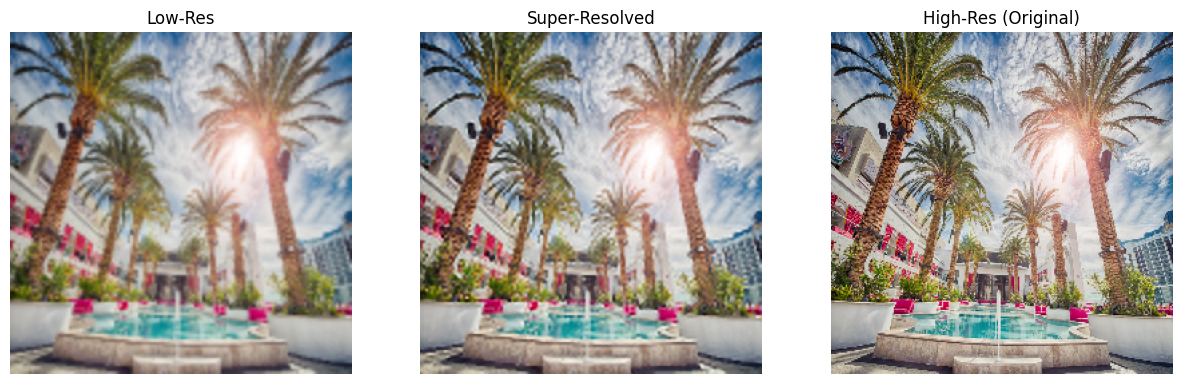

In [22]:
myfunc('/kaggle/input/div2k-dataset/DIV2K_train_HR/DIV2K_train_HR/0003.png',model)

In [23]:
# Save the trained model
model.save("srcnn_model.h5")
print("Model saved successfully!")

Model saved successfully!
